# TUTORIAL DEEP LEARNING: Convolutional Neural Network For Medicinal Plant Recognition.

At the first step we will import all the librairies that we need for our work.

In [1]:
import os
from typing import List, Any
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from keras.backend import clear_session
import keras.models
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
clear_session()

Using TensorFlow backend.


Then we set the path to the "medicinales" plants images for training and testing our model. 

In [2]:
train_dir = 'C:\\Users\\Beranger\\Desktop\\Datasets\\Images\\images_atut\\training\\'
test_dir = 'C:\\Users\\Beranger\\Desktop\\Datasets\\Images\\images_atut\\test\\'
list_repo = os.listdir(train_dir)

We will ensure that all the categories of plants are well-balanced. Unless our model will learn the more predomintant class and won't learn the fewer class of plants.

In [3]:
print('The number of plants per class is: ')
print('===================================')
for rep in list_repo:
    images = os.listdir(train_dir + rep + '\\')
    length: int = len(images)
    print(rep, '---->', length)
print('===================================')

The number of plants per class is: 
BAMBUSA_SPINOSA ----> 1110
BUCHHOLZIA_MACROPHYLLA ----> 1110
CHRYSOPHYLUM_CAINITO ----> 1110
MELIA_AZEDARACH ----> 1110
RAUWOLFIA_VOMITORIA ----> 1110


Now let's see several samples of our plants in order to know what they look like.

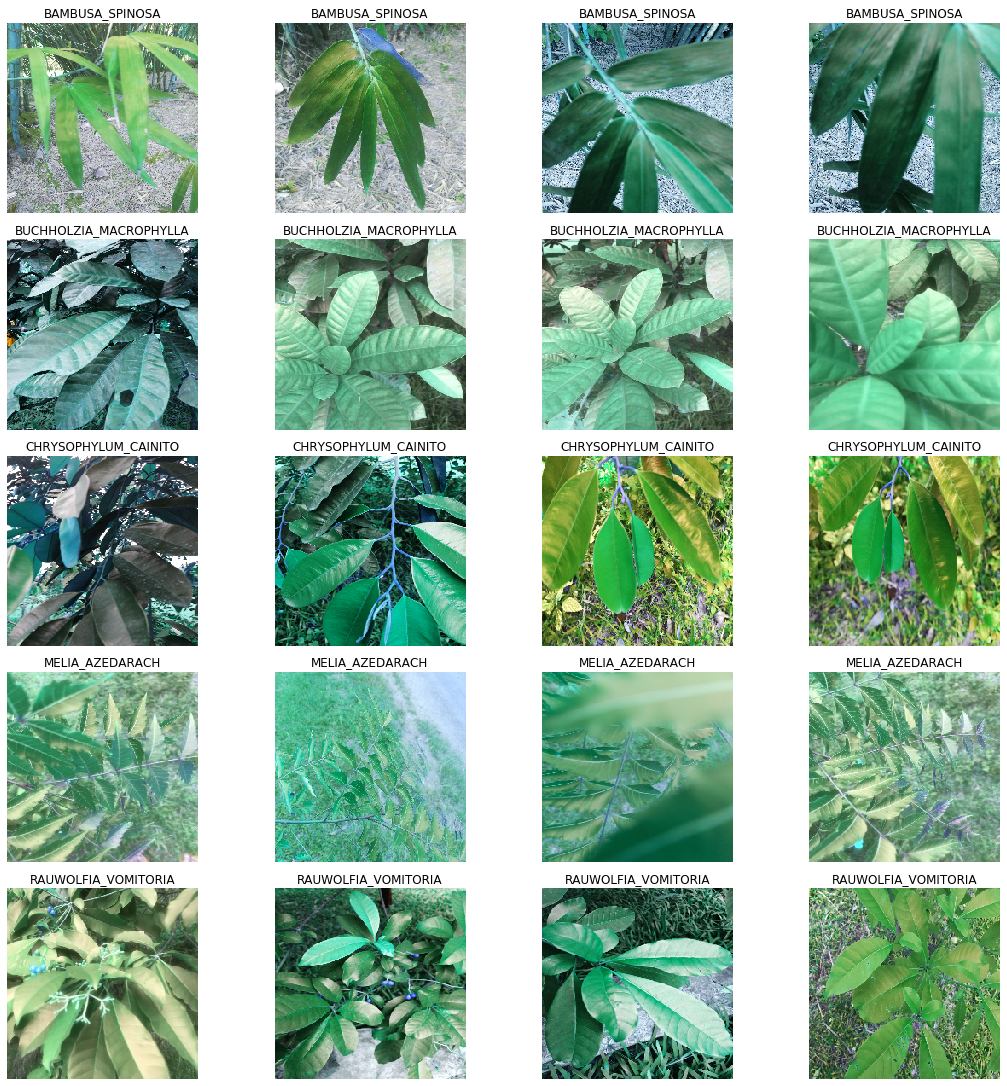

In [4]:
fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        choice = random.choice(os.listdir(train_dir + list_repo[i] + '\\'))
        img = cv2.imread(train_dir + list_repo[i] + '\\' + choice)
        img = cv2.resize(img, (224, 224))
        axs[i, j].set_title(list_repo[i])
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [5]:
def custom_printer(message):
    """This function is just a wrapper for our print function.
    """
    print("====" * 16)
    print(" ------ " + message + " ------")
    print("====" * 16)
    

def all_generator(batch_size=32, target_size=(224, 224)):
    """This function build all the generators and return them in a dictionnary.
    """

    train_datagen = ImageDataGenerator(rotation_range=40,
                                       rescale=1 / 255,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.4,
                                       brightness_range=[0.0, 0.4],
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       validation_split=0.2,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1 / 255)

    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation')

    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      class_mode='categorical')

    output = (train_generator, valid_generator, test_generator)

    return output


In [6]:
def build_tl_model():
    """
    This function takes all the layers of VGG16 to the 4th last ones.
    Add them to a personalized model and freezes them before adding our stacck of dense layers.
    What is a bit special here is that we add some batchnormalization between
    the layers to speed the training and have better result.

    """
    # We create an empty model
    model = keras.models.Sequential()
    # We add the convolutionnal base from VGG16 spacing by batchnormalization
    # each 03 layers
    for (ind, lay) in enumerate(VGG16().layers[:-4]):
        lay.trainable = False
        model.add(lay)
        if ind % 3 == 0 and ind != 0:
            model.add(BatchNormalization())
        if ind % 5 == 0 and ind != 0:
            model.add(Dropout(0.2))

            # Then we add our stack of dense layers
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(5, activation="softmax"))

    # We can now compile our model
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])

    print(model.summary())

    return model

In [9]:
def model_trainer(train_generator, valid_generator, test_generator,
                  epochs=1, patience=1, train_steps_epoch=220,
                  val_steps_epoch=50):
    """
    This function perfoms a transfert learning with a convultionnal base of VGG16 frozen.
    And ends by fine tuning the model.

    """

    # Here we will define the callbacks that we will use during the model training.

    callbacks_freez = [ModelCheckpoint("checkpoint_freez.h5",
                                       monitor='val_loss',
                                       save_best_only=True),
                       EarlyStopping(monitor='val_loss',
                                     patience=patience)]

    # Then we build the model
    model_atut = build_tl_model()
    # We effectively train it
    history_freez = model_atut.fit_generator(train_generator,
                                             steps_per_epoch=train_steps_epoch,
                                             epochs=epochs,
                                             callbacks=callbacks_freez,
                                             validation_data=valid_generator,
                                             validation_steps=val_steps_epoch,
                                             verbose=1)

    # Evaluate on test set
    perf = model_atut.evaluate_generator(test_generator,
                                       steps=len(test_generator),
                                       verbose=1)
    custom_printer(str(perf))

    custom_printer("THE FINE TUNING IS STARTING.")

    callbacks_ft = [ModelCheckpoint("checkpoint_ft.h5",
                                    monitor='val_loss',
                                    save_best_only=True),
                    EarlyStopping(monitor='val_loss',
                                  patience=patience)]

    # We start by setting to trainable all the parameters of our model.

    model_atut.trainable = False
    model_ft = keras.models.Sequential()
    model_ft.add(InputLayer(input_shape=(224, 224, 3)))

    for lay in model_atut.layers[:-11]:
        lay.trainable = False
        model_ft.add(lay)

    for lay in model_atut.layers[-11:]:
        lay.trainable = True
        model_ft.add(lay)

    model_ft.compile(loss="categorical_crossentropy",
                     optimizer="rmsprop",
                     metrics=['accuracy'])

    print(model_ft.summary())

    history_ft = model_ft.fit_generator(train_generator,
                                        steps_per_epoch=train_steps_epoch,
                                        epochs=epochs,
                                        callbacks=callbacks_ft,
                                        validation_data=valid_generator,
                                        validation_steps=val_steps_epoch,
                                        verbose=1)

    # Evaluate on test set
    perf = model_ft.evaluate_generator(test_generator,
                                       steps=len(test_generator),
                                       verbose=1)
    custom_printer(str(perf))

    # Save the model
    model_json = model_ft.to_json()
    with open("model_arch.json", "w") as json_file:
        json_file.write(model_json)
    model_ft.save_weights("my_model_weights.h5")
    custom_printer(" WELL DONE YOUR FINAL MODEL IS READY.")

    return history_ft, history_freez


def inference(data, arch_path="model_arch.json", weights_path="my_model_weights.h5"):
    """This function will perform predictions.
    """
    with open(arch_path, "r") as json_file:
        file = json_file.read()

    model = keras.models.model_from_json(file)
    model.load_weights(weights_path)
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['acc'])
    predictions: List[Any] = [np.argmax(proba) for proba in model.predict(data)]
    return predictions

In [11]:
%%time
history_ft, history_freez = model_trainer(*all_generator(), epochs=200, patience=10)

Found 5547 images belonging to 5 classes.
Found 1107 images belonging to 5 classes.
Found 997 images belonging to 5 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________

Epoch 28/200
220/220 [==============================] - 619s 3s/step - loss: 0.1881 - acc: 0.9303 - val_loss: 0.2227 - val_acc: 0.9174
Epoch 29/200
220/220 [==============================] - 611s 3s/step - loss: 0.1975 - acc: 0.9337 - val_loss: 0.2006 - val_acc: 0.9395
Epoch 30/200
220/220 [==============================] - 615s 3s/step - loss: 0.2078 - acc: 0.9304 - val_loss: 0.2461 - val_acc: 0.9244
Epoch 31/200
220/220 [==============================] - 618s 3s/step - loss: 0.1882 - acc: 0.9338 - val_loss: 0.1954 - val_acc: 0.9250
Epoch 32/200
220/220 [==============================] - 618s 3s/step - loss: 0.1687 - acc: 0.9432 - val_loss: 0.1877 - val_acc: 0.9395
Epoch 33/200
220/220 [==============================] - 613s 3s/step - loss: 0.1820 - acc: 0.9331 - val_loss: 0.2062 - val_acc: 0.9276
Epoch 34/200
220/220 [==============================] - 609s 3s/step - loss: 0.1806 - acc: 0.9388 - val_loss: 0.2809 - val_acc: 0.9067
Epoch 35/200
220/220 [==============================] -

Epoch 1/200
220/220 [==============================] - 640s 3s/step - loss: 1.1627 - acc: 0.6796 - val_loss: 10.2319 - val_acc: 0.2770
Epoch 2/200
220/220 [==============================] - 616s 3s/step - loss: 0.4516 - acc: 0.8486 - val_loss: 0.8634 - val_acc: 0.8557
Epoch 3/200
220/220 [==============================] - 611s 3s/step - loss: 0.3665 - acc: 0.8891 - val_loss: 1.3444 - val_acc: 0.7726
Epoch 4/200
220/220 [==============================] - 614s 3s/step - loss: 0.3002 - acc: 0.9040 - val_loss: 0.5837 - val_acc: 0.8904
Epoch 5/200
220/220 [==============================] - 627s 3s/step - loss: 0.2460 - acc: 0.9235 - val_loss: 0.3617 - val_acc: 0.8945
Epoch 6/200
220/220 [==============================] - 612s 3s/step - loss: 0.2025 - acc: 0.9354 - val_loss: 0.2310 - val_acc: 0.9219
Epoch 7/200
220/220 [==============================] - 605s 3s/step - loss: 0.2082 - acc: 0.9357 - val_loss: 0.5538 - val_acc: 0.8960
Epoch 8/200
220/220 [==============================] - 606s 3

# END